In [16]:
import copy
import torch
import numpy as np
from omegaconf import OmegaConf

from sorrel.agents import Agent
from sorrel.models.pytorch.ppo import PyTorchPPO
from sorrel.examples.leakyemotions.custom_observation_spec import LeakyEmotionsObservationSpec
from sorrel.examples.leakyemotions.world import LeakyEmotionsWorld
from sorrel.examples.leakyemotions.entities import EmptyEntity
from sorrel.examples.leakyemotions.env import LeakyEmotionsEnv


In [17]:
# define the testing environment
env_templates = []

# define the target locs to place the objects
target_locs = []

In [18]:
# load cfg
cfg = {
        "experiment": {
            "epochs": 5000,
            "max_turns": 50,
            "record_period": 50,
        },
        "model": {
            "agent_vision_radius": 3,
            "epsilon_decay": 0.0001,
        },
        "world": {
            "agents": 5,
            "wolves": 0,
            "height": 25,
            "width": 25,
            "spawn_prob": 0.01,
        },
    }

config = OmegaConf.create(cfg)

# construct the world
world = LeakyEmotionsWorld(config=config, default_entity=EmptyEntity())

# construct the environment
env = LeakyEmotionsEnv(world, config)

env.setup_agents()

env_templates.append(env)


In [19]:
# generate the maps 

epochs = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
v_heatmap_lst = []

for epoch in epochs:
    for agent in env.agents:
        agent.model.load(f'../../leakyemotions/save_pretrained/trial{epoch}.pkl')

    # parameters
    world_size = env_templates[0].world.height
    num_reps = 100
    ixs = 0

    # main
    for env in env_templates: 

        # find the empty locations
        empty_locs = []
        for i in range(env.world.height):
            for j in range(env.world.width):
                if env.world.map[i,j,1].kind == 'EmptyEntity':  
                    empty_locs.append((i,j,1)) 
        
        # create an empty template for the heatmap 
        v_heatmap = np.empty((world_size,world_size))
        v_heatmap[:] = np.nan

        # iteratively place the agent on every empty location in the env, 
        # then record the model's output (Q/V/...), and store it in the 
        # heatmap template 

        if empty_locs is not None:
            print(empty_locs)
            available_locs = empty_locs
        else:
            available_locs = empty_locs

        for loc in available_locs: 
            env_ = copy.deepcopy(env)
            for agent_ in env.agents:
                agent = copy.deepcopy(agent)
            # agent = Agent(model=model, cfg=cfg, ixs=ixs)
            # place the agent
            env_.world.map[loc] = agent
            agent.location = loc
            # generate the agent's state
            state = agent.pov(env_.world)

            val_estimation_trials = [] 

            for _ in range(num_reps):

                state_values = []
                for action in np.arange(agent.model.action_space):
                    _, state_value, _ = agent.model.policy.evaluate(torch.from_numpy(state), torch.scalar_tensor(action))
                    state_values.append(state_value.detach())

                state_value = max(state_values)
                val_estimation_trials.append(state_value) 
            
            # store the value of interest in the heatmap 
            v_m = np.mean(val_estimation_trials)
            v_heatmap[loc[0], loc[1]] = v_m 

        v_heatmap_lst.append(v_heatmap)
        print(len(v_heatmap_lst))



[(1, 1, 1), (1, 2, 1), (1, 3, 1), (1, 4, 1), (1, 5, 1), (1, 6, 1), (1, 7, 1), (1, 8, 1), (1, 9, 1), (1, 10, 1), (1, 11, 1), (1, 12, 1), (1, 13, 1), (1, 14, 1), (1, 16, 1), (1, 17, 1), (1, 18, 1), (1, 19, 1), (1, 20, 1), (1, 21, 1), (1, 22, 1), (1, 23, 1), (2, 1, 1), (2, 2, 1), (2, 3, 1), (2, 4, 1), (2, 5, 1), (2, 6, 1), (2, 7, 1), (2, 8, 1), (2, 9, 1), (2, 10, 1), (2, 11, 1), (2, 12, 1), (2, 13, 1), (2, 14, 1), (2, 15, 1), (2, 16, 1), (2, 17, 1), (2, 18, 1), (2, 19, 1), (2, 20, 1), (2, 21, 1), (2, 22, 1), (2, 23, 1), (3, 1, 1), (3, 2, 1), (3, 3, 1), (3, 4, 1), (3, 5, 1), (3, 6, 1), (3, 7, 1), (3, 8, 1), (3, 9, 1), (3, 10, 1), (3, 11, 1), (3, 12, 1), (3, 13, 1), (3, 14, 1), (3, 15, 1), (3, 16, 1), (3, 17, 1), (3, 18, 1), (3, 19, 1), (3, 20, 1), (3, 21, 1), (3, 22, 1), (3, 23, 1), (4, 1, 1), (4, 2, 1), (4, 3, 1), (4, 4, 1), (4, 5, 1), (4, 6, 1), (4, 7, 1), (4, 8, 1), (4, 9, 1), (4, 10, 1), (4, 11, 1), (4, 12, 1), (4, 13, 1), (4, 14, 1), (4, 15, 1), (4, 16, 1), (4, 17, 1), (4, 18, 1), (4,

Length of v_heatmap_lst: 11
0


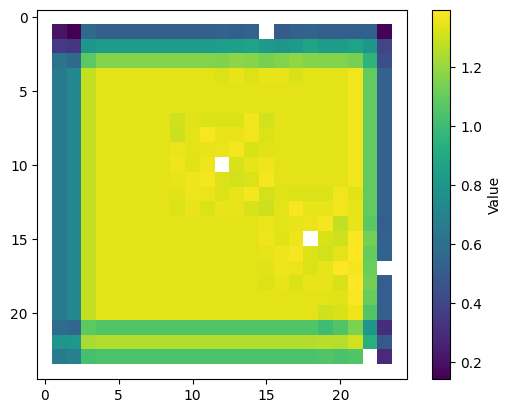

1


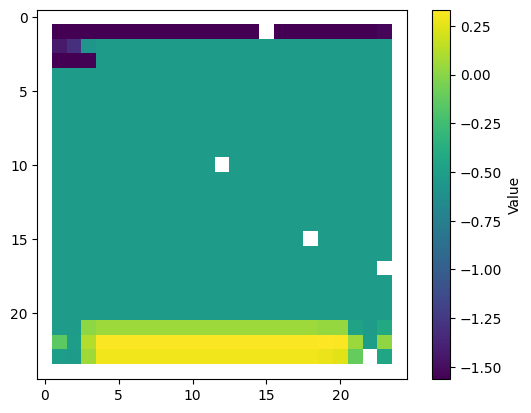

2


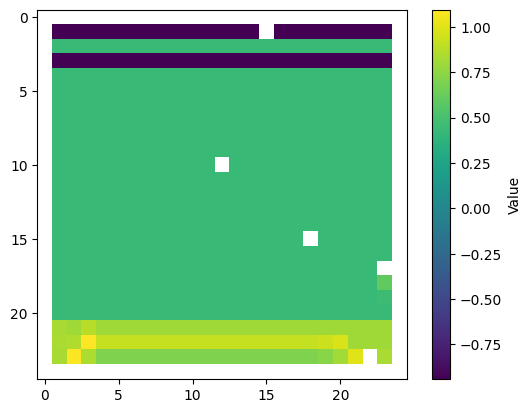

3


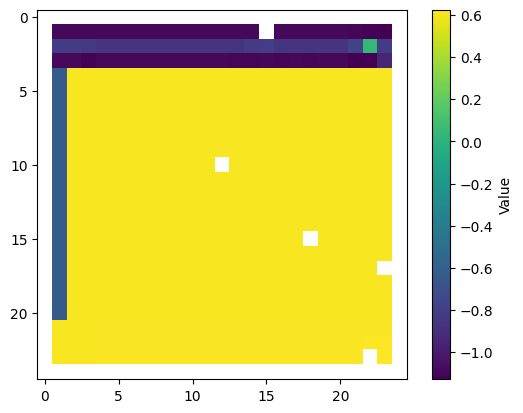

4


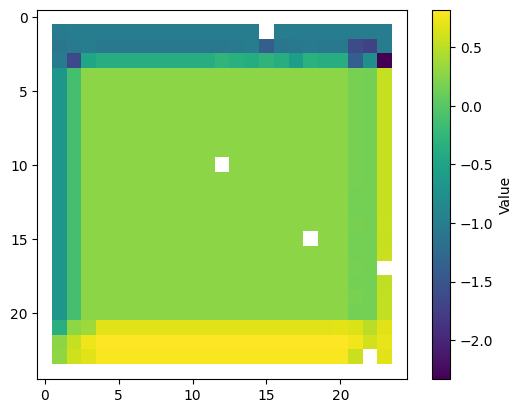

5


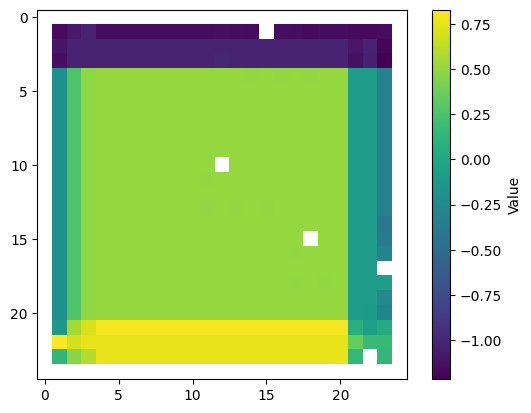

6


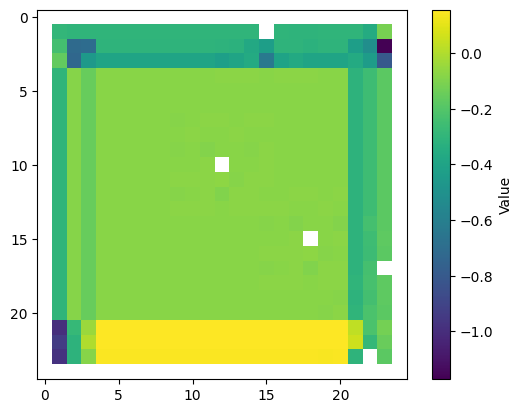

7


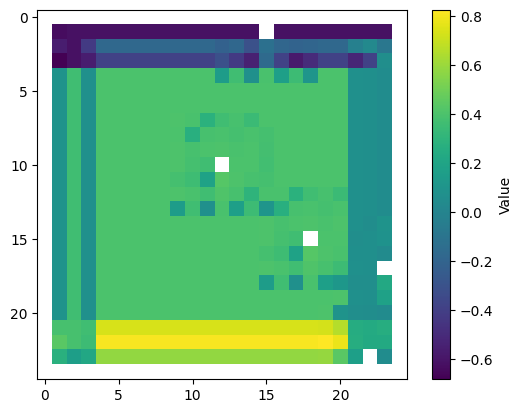

8


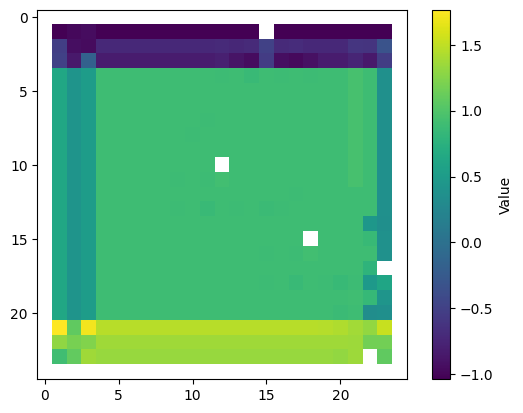

9


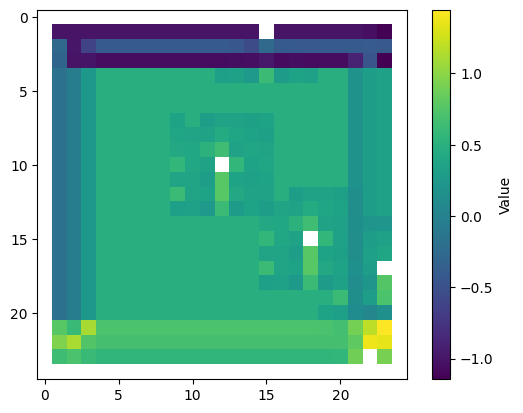

10


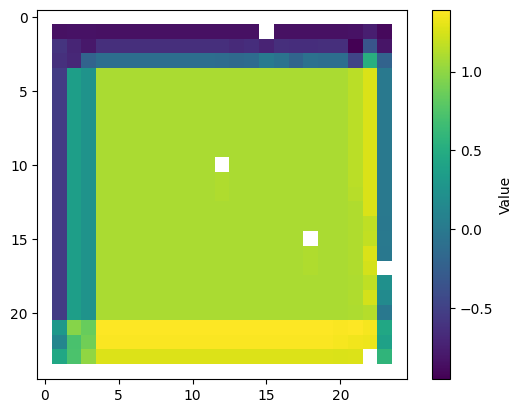

[[       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan]
 [       nan 0.2092067  0.14187957 0.57667185 0.52233955 0.52233955
  0.52233955 0.52233955 0.52233955 0.52233955 0.52233955 0.52233955
  0.54079832 0.51682941 0.5412728         nan 0.49525642 0.52732774
  0.54111324 0.52233955 0.52233955 0.52289438 0.53054375 0.15363783
         nan]
 [       nan 0.34873364 0.34091041 0.80721353 0.8343147  0.8343147
  0.8343147  0.8343147  0.8343147  0.8343147  0.8343147  0.8343147
  0.8377135  0.85384277 0.86889209 0.81403777 0.79729451 0.81418873
  0.87115887 0.8343147  0.8343147  0.86876519 0.80419105 0.40463531
         nan]
 [       nan 0.62509501 0.57251973 1.0795062  1.15593299 1.15593299
  1.15593299 1.15593299 1.15593299 1.15593299 1.15593299 1.15593299
  1.1521

In [20]:
import matplotlib.pyplot as plt

print("Length of v_heatmap_lst:", len(v_heatmap_lst))
for i in range(0, len(epochs)):
    print(i)
    plt.imshow(v_heatmap_lst[i])
    plt.colorbar(label='Value')
    plt.show()

print(v_heatmap_lst[0])